In [464]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



In [465]:
f1_races = pd.read_csv("data/F1 Races 2000-2024.csv")
drivers = pd.read_csv("data/drivers.csv")
pit_stops = pd.read_csv("data/pit_stops.csv")
pit_stops

,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,17:05:23,26.898,26898
1,841,30,1,1,17:05:52,25.021,25021
2,841,17,1,11,17:20:48,23.426,23426
3,841,4,1,12,17:22:34,23.251,23251
4,841,13,1,13,17:24:10,23.842,23842
...,...,...,...,...,...,...,...
11366,1144,840,2,32,17:52:48,22.053,22053
11367,1144,1,1,34,17:55:17,21.694,21694
11368,1144,4,2,37,18:00:10,22.437,22437
11369,1144,855,2,39,18:03:21,28.765,28765


In [466]:
#show driverRef = leclerc
drivers[drivers['driverRef'] == 'tsunoda']

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
850,852,tsunoda,22,TSU,Yuki,Tsunoda,2000-05-11,Japanese,http://en.wikipedia.org/wiki/Yuki_Tsunoda


In [467]:
# convert date to datetime
f1_races["date"] = pd.to_datetime(f1_races["date"])

# Create a copy of the dataset for feature engineering
f1_processed = f1_races.copy()

### Mapping grand prix names

In [468]:
# Initialize an empty list to store DataFrames for each year
race_circuit_info = []

# Loop through each year and process race data
for year in range(2000, 2025):
    race_data_year = f1_processed[f1_processed['year'] == year]
    
    if not race_data_year.empty:
        race_data_year = race_data_year.groupby(['date', 'circuitId']).size().reset_index(name='count')
        race_data_year['year'] = year  # Add a year column for reference
        race_circuit_info.append(race_data_year[['year', 'date', 'circuitId']])  # Keep only relevant columns

# Combine all yearly DataFrames into a single DataFrame
df_race_circuit_all_years = pd.concat(race_circuit_info, ignore_index=True)

# Display the final DataFrame
print(df_race_circuit_all_years)

df_race_circuit_all_years.to_csv("data/circuitid_years.csv", index=False)

     year       date  circuitId
0    2000 2000-03-12          1
1    2000 2000-03-26         18
2    2000 2000-04-09         21
3    2000 2000-04-23          9
4    2000 2000-05-07          4
..    ...        ...        ...
462  2024 2024-05-26          6
463  2024 2024-06-09          7
464  2024 2024-06-23          4
465  2024 2024-06-30         70
466  2024 2024-07-07          9

[467 rows x 3 columns]


In [469]:
gp_name_mapping = {
    1: "Australian Grand Prix",
    2: "Malaysian Grand Prix",
    3: "Bahrain Grand Prix",
    4: "Spanish Grand Prix",
    5: "San Marino Grand Prix",
    6: "Monaco Grand Prix",
    7: "Canadian Grand Prix",
    8: "French Grand Prix",
    9: "British Grand Prix",
    10: "German Grand Prix",
    11: "Hungarian Grand Prix",
    12: "Austrian Grand Prix",
    13: "Belgian Grand Prix",
    14: "Italian Grand Prix",
    15: "United States Grand Prix (Indianapolis)",
    16: "European Grand Prix (Valencia)",
    17: "Chinese Grand Prix",
    18: "Mexican Grand Prix",
    19: "Turkish Grand Prix",
    20: "Indian Grand Prix",
    21: "Brazilian Grand Prix",
    22: "Singapore Grand Prix",
    24: "Abu Dhabi Grand Prix",
    32: "United States Grand Prix",
    34: "Pacific Grand Prix",
    35: "South African Grand Prix",
    39: "Dutch Grand Prix",
    68: "Tuscan Grand Prix",
    69: "Qatar Grand Prix",
    70: "Austrian Grand Prix",
    71: "Eifel Grand Prix",
    73: "Azerbaijan Grand Prix",
    75: "Sakhir Grand Prix",
    76: "70th Anniversary Grand Prix",
    77: "Saudi Arabian Grand Prix",
    78: "Japanese Grand Prix",
    79: "Miami Grand Prix",
    80: "São Paulo Grand Prix"
}

f1_processed["circuitId"] = f1_processed["circuitId"].astype(int)

# Map circuitId to GP names
f1_processed["GP Name"] = f1_processed["circuitId"].map(gp_name_mapping)

# Display the updated dataset
f1_processed.head()

,year,round,circuitId,date,rainy,Turns,Length,driverId,constructorId,grid,...,statusId,Weighted_Top_3_Probability,Weighted_Top_3_Prob_Length,position_previous_race,nro_cond_escuderia,raceId,points,prom_points_10,Top 3 Finish,GP Name
0,2000,1,1,2000-03-12,0,14,5.278,2,20,15,...,12,0.087719,0.090909,8.0,2,158,0.0,9.4,0,Australian Grand Prix
1,2000,1,1,2000-03-12,0,14,5.278,14,1,2,...,5,0.208333,0.222222,20.0,2,158,0.0,47.6,0,Australian Grand Prix
2,2000,1,1,2000-03-12,0,14,5.278,15,17,6,...,5,0.048387,0.083333,20.0,2,158,0.0,8.5,0,Australian Grand Prix
3,2000,1,1,2000-03-12,0,14,5.278,18,3,21,...,5,0.160494,0.235294,20.0,2,158,0.0,1.2,0,Australian Grand Prix
4,2000,1,1,2000-03-12,0,14,5.278,21,22,9,...,1,0.076923,0.100000,11.0,1,158,2.0,4.5,0,Australian Grand Prix


### word2vec model

In [470]:
# Ensure that the relevant columns are strings
f1_processed["circuitId"] = f1_processed["circuitId"].astype(str)
f1_processed["driverId"] = f1_processed["driverId"].astype(str)

# Prepare data: Group circuits raced on per driver as lists of strings
driver_circuit_history = f1_processed.groupby("driverId")["circuitId"].apply(lambda x: [str(c) for c in x]).tolist()

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=driver_circuit_history, vector_size=50, window=5, min_count=1, sg=1, workers=4, epochs=50)

# Save model
word2vec_model.save("driver_track_word2vec.model")
print("Word2Vec model trained and saved.")

# Test the model: Find similar circuits
test_circuit = f1_processed["circuitId"].iloc[0]
similar_circuits = word2vec_model.wv.most_similar(test_circuit, topn=5)
print(f"\nMost similar circuits to {test_circuit}:")
print(similar_circuits)

# Test the model: Find similar drivers
test_driver = f1_processed["driverId"].iloc[0]
similar_drivers = word2vec_model.wv.most_similar(test_driver, topn=5)
print(f"\nMost similar drivers to {test_driver}:")
print(similar_drivers)

Word2Vec model trained and saved.

Most similar circuits to 1:
[('7', 0.5855786204338074), ('14', 0.5651478171348572), ('17', 0.557908296585083), ('18', 0.5529857277870178), ('22', 0.551795482635498)]

Most similar drivers to 2:
[('10', 0.7589106559753418), ('8', 0.5951002836227417), ('12', 0.5797758102416992), ('19', 0.5650588274002075), ('20', 0.5383695960044861)]


In [471]:
# Prepare data for Word2Vec
driver_circuit_history = f1_processed.groupby("driverId")["circuitId"].apply(lambda x: [str(c) for c in x]).tolist()

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=driver_circuit_history, vector_size=50, window=5, min_count=1, sg=1, workers=4, epochs=50)

# Map similar circuits to their names
similar_circuits = word2vec_model.wv.most_similar("1", topn=5)

# Convert gp_name_mapping keys to strings
gp_name_mapping = {str(k): v for k, v in gp_name_mapping.items()}

# Map circuitId to GP names
mapped_similar_circuits = [(circuit, gp_name_mapping.get(circuit, "Unknown Circuit")) for circuit, _ in similar_circuits]

# Display the mapped results
mapped_similar_circuits

[('7', 'Canadian Grand Prix'),
 ('14', 'Italian Grand Prix'),
 ('17', 'Chinese Grand Prix'),
 ('18', 'Mexican Grand Prix'),
 ('22', 'Singapore Grand Prix')]

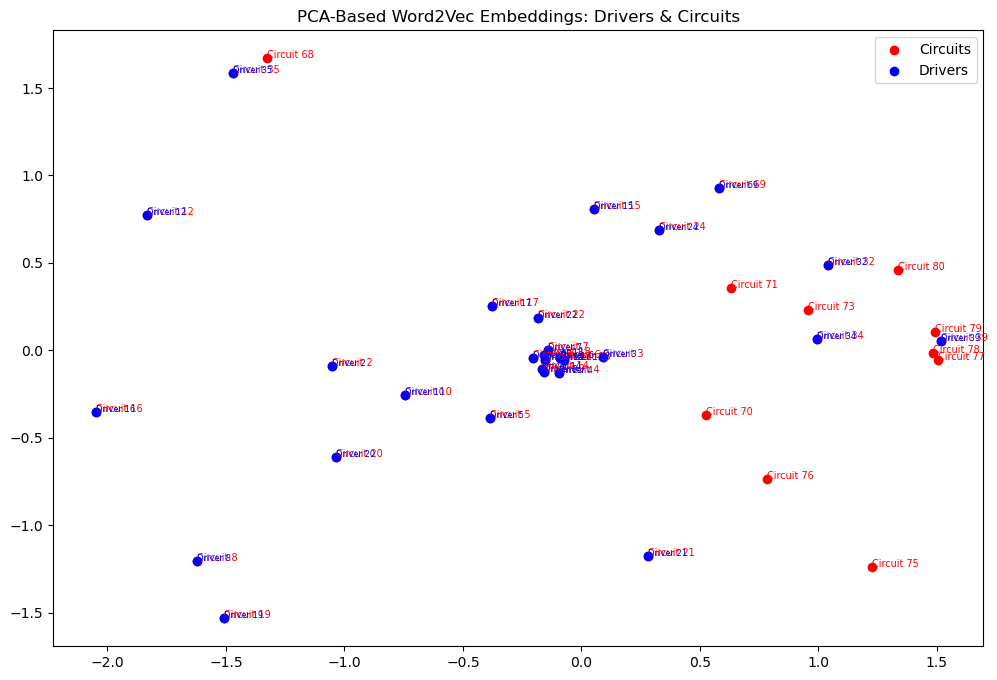

In [472]:
# Extract all entities (both drivers and circuits) from Word2Vec model
all_entities = list(word2vec_model.wv.index_to_key)
vectors = np.array([word2vec_model.wv[entity] for entity in all_entities])

# Reduce dimensionality with PCA (Faster than t-SNE)
pca = PCA(n_components=2)
vectors_pca = pca.fit_transform(vectors)

# Convert results into a DataFrame
embedding_df = pd.DataFrame(vectors_pca, index=all_entities, columns=["x", "y"])

# Ensure both drivers and circuits are included
circuit_points = embedding_df.loc[embedding_df.index.isin(f1_races["circuitId"].astype(str).unique())]
driver_points = embedding_df.loc[embedding_df.index.isin(f1_races["driverId"].astype(str).unique())]

# Plot the embeddings with both circuits and drivers
plt.figure(figsize=(12, 8))

# Plot circuits
plt.scatter(circuit_points["x"], circuit_points["y"], color="red", label="Circuits")
for circuit, (x, y) in circuit_points.iterrows():
    plt.text(x, y, f"Circuit {circuit}", fontsize=7, color="red")

# Plot drivers
plt.scatter(driver_points["x"], driver_points["y"], color="blue", label="Drivers")
for driver, (x, y) in driver_points.iterrows():
    plt.text(x, y, f"Driver {driver}", fontsize=6, color="blue")

plt.title("PCA-Based Word2Vec Embeddings: Drivers & Circuits")
plt.legend()
plt.show()

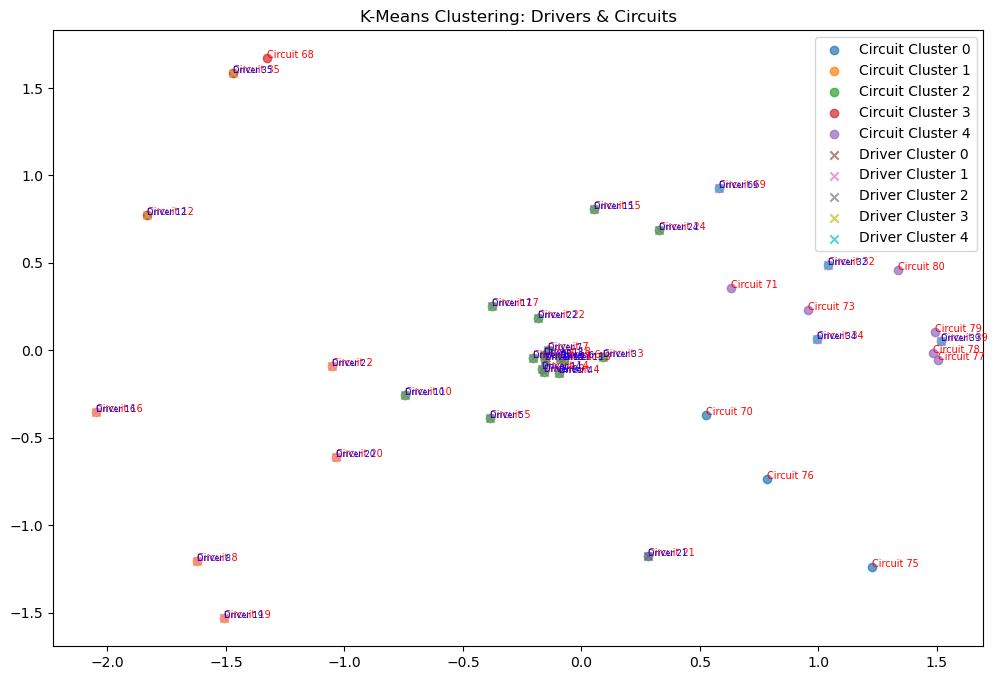

In [473]:
from sklearn.cluster import KMeans

# Apply K-Means clustering
num_clusters = 5  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
embedding_df["cluster"] = kmeans.fit_predict(vectors_pca)

# Separate circuits and drivers into their clusters
circuit_clusters = embedding_df.loc[embedding_df.index.isin(f1_races["circuitId"].astype(str).unique())]
driver_clusters = embedding_df.loc[embedding_df.index.isin(f1_races["driverId"].astype(str).unique())]

# Plot the clusters
plt.figure(figsize=(12, 8))

# Plot circuits
for cluster in range(num_clusters):
    cluster_data = circuit_clusters[circuit_clusters["cluster"] == cluster]
    plt.scatter(cluster_data["x"], cluster_data["y"], label=f"Circuit Cluster {cluster}", alpha=0.7)

# Plot drivers
for cluster in range(num_clusters):
    cluster_data = driver_clusters[driver_clusters["cluster"] == cluster]
    plt.scatter(cluster_data["x"], cluster_data["y"], marker="x", label=f"Driver Cluster {cluster}", alpha=0.7)

# Add labels for circuits
for circuit, (x, y, cluster) in circuit_clusters.iterrows():
    plt.text(x, y, f"Circuit {circuit}", fontsize=7, color="red")

# Add labels for drivers
for driver, (x, y, cluster) in driver_clusters.iterrows():
    plt.text(x, y, f"Driver {driver}", fontsize=6, color="blue")

plt.title("K-Means Clustering: Drivers & Circuits")
plt.legend()
plt.show()

### Feature Engineering

**Driver-Track Performance Features**

In [474]:
f1_processed["podium"] = (f1_processed["Top 3 Finish"] == 1).astype(int)

driver_circuit_stats = f1_processed.groupby(["driverId", "circuitId"]).agg(
    avg_points=("points", "mean"),
    podium_rate=("podium", "mean")
).reset_index()

f1_processed = f1_processed.merge(driver_circuit_stats, on=["driverId", "circuitId"], how="left")



**Weather Impact Features**

In [475]:
f1_processed["DNF"] = (f1_processed["statusId"] != 1).astype(int)

driver_weather_stats = f1_processed.groupby(["driverId", "rainy"]).agg(
    DNF_rate=("DNF", "mean"),
    avg_points_in_condition=("points", "mean")
).reset_index()

driver_weather_stats = driver_weather_stats.pivot(index="driverId", columns="rainy", values=["DNF_rate", "avg_points_in_condition"])
driver_weather_stats.columns = ["DNF_rate_dry", "DNF_rate_wet", "avg_points_dry", "avg_points_wet"]
driver_weather_stats = driver_weather_stats.reset_index()

f1_processed = f1_processed.merge(driver_weather_stats, on="driverId", how="left")

f1_processed.head()

,year,round,circuitId,date,rainy,Turns,Length,driverId,constructorId,grid,...,Top 3 Finish,GP Name,podium,avg_points,podium_rate,DNF,DNF_rate_dry,DNF_rate_wet,avg_points_dry,avg_points_wet
0,2000,1,1,2000-03-12,0,14,5.278,2,20,15,...,0,Australian Grand Prix,0,1.909091,0.090909,1,0.651786,0.625000,12.660714,13.888889
1,2000,1,1,2000-03-12,0,14,5.278,14,1,2,...,0,Australian Grand Prix,0,2.555556,0.222222,1,0.526316,0.500000,18.810526,20.112903
2,2000,1,1,2000-03-12,0,14,5.278,15,17,6,...,0,Australian Grand Prix,0,1.000000,0.083333,1,0.598425,0.734940,11.287402,12.765060
3,2000,1,1,2000-03-12,0,14,5.278,18,3,21,...,0,Australian Grand Prix,0,6.176471,0.235294,1,0.519774,0.424242,41.209040,33.439394
4,2000,1,1,2000-03-12,0,14,5.278,21,22,9,...,0,Australian Grand Prix,0,3.000000,0.100000,0,0.580952,0.695652,12.219048,12.594203


In [476]:
# Rename duplicate columns (fix "_x" and "_y" issues)
f1_processed = f1_processed.rename(columns={
    "DNF_rate_dry_x": "DNF_rate_dry",
    "DNF_rate_dry_y": "DNF_rate_dry",
    "DNF_rate_wet_x": "DNF_rate_wet",
    "DNF_rate_wet_y": "DNF_rate_wet",
    "avg_points_dry_x": "avg_points_dry",
    "avg_points_dry_y": "avg_points_dry",
    "avg_points_wet_x": "avg_points_wet",
    "avg_points_wet_y": "avg_points_wet",
    "avg_points_x": "avg_points",
    "avg_points_y": "avg_points",
    "podium_rate_x": "podium_rate",
    "podium_rate_y": "podium_rate"
})

# Drop any unnecessary duplicate columns if they exist
f1_processed = f1_processed.loc[:, ~f1_processed.columns.duplicated()]

f1_processed.head()

,year,round,circuitId,date,rainy,Turns,Length,driverId,constructorId,grid,...,Top 3 Finish,GP Name,podium,avg_points,podium_rate,DNF,DNF_rate_dry,DNF_rate_wet,avg_points_dry,avg_points_wet
0,2000,1,1,2000-03-12,0,14,5.278,2,20,15,...,0,Australian Grand Prix,0,1.909091,0.090909,1,0.651786,0.625000,12.660714,13.888889
1,2000,1,1,2000-03-12,0,14,5.278,14,1,2,...,0,Australian Grand Prix,0,2.555556,0.222222,1,0.526316,0.500000,18.810526,20.112903
2,2000,1,1,2000-03-12,0,14,5.278,15,17,6,...,0,Australian Grand Prix,0,1.000000,0.083333,1,0.598425,0.734940,11.287402,12.765060
3,2000,1,1,2000-03-12,0,14,5.278,18,3,21,...,0,Australian Grand Prix,0,6.176471,0.235294,1,0.519774,0.424242,41.209040,33.439394
4,2000,1,1,2000-03-12,0,14,5.278,21,22,9,...,0,Australian Grand Prix,0,3.000000,0.100000,0,0.580952,0.695652,12.219048,12.594203


### Podium Prediction

In [477]:
# Ensure driverId is a string before merging
f1_processed["driverId"] = f1_processed["driverId"].astype(str)

# Ensure the cluster assignments exist
if "cluster" not in f1_processed.columns:
    f1_processed["cluster"] = f1_processed["driverId"].map(embedding_df["cluster"])

# Check if the column exists after mapping
print("Cluster column added:", "cluster" in f1_processed.columns)

Cluster column added: True


In [478]:
# Compute historical podium % per cluster
if "cluster_podium_rate" not in f1_processed.columns:
    cluster_podium_stats = f1_processed.groupby("cluster")["Top 3 Finish"].mean().reset_index()
    cluster_podium_stats.rename(columns={"Top 3 Finish": "cluster_podium_rate"}, inplace=True)
    
    # Merge back into dataset
    f1_processed = f1_processed.merge(cluster_podium_stats, on="cluster", how="left")

# Check if the column exists after merging
print("Cluster podium rate column added:", "cluster_podium_rate" in f1_processed.columns)

Cluster podium rate column added: True


### Train XGBoost model

In [479]:
# Normalize grid position so that lower numbers are smaller (to reduce over-reliance)
f1_processed["grid_normalized"] = 1 / (f1_processed["grid"] + 1)  # Adding 1 to avoid division by zero

# Boost driver performance features
f1_processed["weighted_avg_points"] = f1_processed["avg_points"] * 1.5  # Increase impact
f1_processed["weighted_podium_rate"] = f1_processed["podium_rate"] * 1.5
f1_processed["weighted_DNF_rate_wet"] = f1_processed["DNF_rate_wet"] * 1.3


In [480]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

feature_columns = ["grid_normalized", "DNF_rate_dry", "weighted_DNF_rate_wet", 
                   "avg_points_dry", "avg_points_wet", "weighted_podium_rate", "weighted_avg_points"]

# Prepare training data with new features
X = f1_processed[feature_columns]
y = f1_processed["Top 3 Finish"]

# Handle missing values
X.fillna(X.median(), inplace=True)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost With Adjusted Feature Weights
xgb_model_adjusted = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)
xgb_model_adjusted.fit(X_train, y_train)

# Evaluate the New Model
y_pred_adjusted = xgb_model_adjusted.predict(X_test)
accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)

print(f"\nXGBoost Model (Adjusted Features) Accuracy: {accuracy_adjusted:.4f}")
print("\n--- Classification Report (Adjusted Features) ---")
print(classification_report(y_test, y_pred_adjusted))


XGBoost Model (Adjusted Features) Accuracy: 0.8923

--- Classification Report (Adjusted Features) ---
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1700
           1       0.61      0.56      0.59       268

    accuracy                           0.89      1968
   macro avg       0.77      0.75      0.76      1968
weighted avg       0.89      0.89      0.89      1968



/tmp/ipykernel_10536/1367107876.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.median(), inplace=True)
/home/jovyan/.rsm-msba/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:00:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### Using past real data to confirm the accuracy of the model

In [ ]:
# Define driver IDs for the Australian GP
driver_ids = ["846", "857", "50", "847", "852", "848", "844", "1", "842", "832"]

# Map driver IDs to reference names
driver_id_mapping = {
    "846": "NOR", "857": "PIA", "50": "VER", "847": "RUS", "852": "TSU",
    "848": "ALB", "844": "LEC", "1": "HAM", "842": "GAS", "832": "SAI"
}

# Assign actual grid positions
grid_positions = {
    "846": 6, "857": 8, "50": 5, "847": 1, "852": 7, 
    "848": 17, "844": 4, "1": 10, "842": 3, "832": 2
}

# Define correct feature columns (with weighted features)
feature_columns = ["grid_normalized", "DNF_rate_dry", "weighted_DNF_rate_wet", 
                   "avg_points_dry", "avg_points_wet", "weighted_podium_rate", "weighted_avg_points"]

upcoming_race_data = []
driver_names = []  # Store driver reference names

for driver_id in driver_ids:
    driver_data = f1_processed[f1_processed["driverId"] == driver_id]

    if driver_data.empty:
        print(f"Warning: No race data found for Driver {driver_id}, using default values.")
        driver_stats = {
            "grid_normalized": 1 / (grid_positions.get(driver_id, 99) + 1),
            "DNF_rate_dry": 0.15,  # Default values
            "weighted_DNF_rate_wet": 0.20 * 1.3,
            "avg_points_dry": 10.0,
            "avg_points_wet": 9.0,
            "weighted_podium_rate": 0.25 * 1.5,
            "weighted_avg_points": 10.5 * 1.5
        }
    else:
        driver_stats = {
            "grid_normalized": 1 / (grid_positions.get(driver_id, 99) + 1),
            "DNF_rate_dry": driver_data["DNF_rate_dry"].mean(),
            "weighted_DNF_rate_wet": driver_data["DNF_rate_wet"].mean() * 1.3,
            "avg_points_dry": driver_data["avg_points_dry"].mean(),
            "avg_points_wet": driver_data["avg_points_wet"].mean(),
            "weighted_podium_rate": driver_data["podium_rate"].mean() * 1.5,
            "weighted_avg_points": driver_data["avg_points"].mean() * 1.5
        }

    # Store driver reference name
    driver_names.append(driver_id_mapping.get(driver_id, driver_id))  # Use reference name, else keep ID

    # Append valid driver data
    upcoming_race_data.append(driver_stats)

upcoming_race_df = pd.DataFrame(upcoming_race_data)

upcoming_race_df["grid_normalized"] = upcoming_race_df["grid_normalized"].astype(float)

upcoming_race_df = upcoming_race_df[feature_columns]

# Predict podium probabilities with the retrained model
predicted_podiums = xgb_model_adjusted.predict_proba(upcoming_race_df)[:, 1]

upcoming_race_df["Driver"] = driver_names 
upcoming_race_df["Podium Probability"] = pd.Series(predicted_podiums)  

upcoming_race_df = upcoming_race_df.sort_values(by="Podium Probability", ascending=False)

print("\nPredicted Podium Probabilities for 2024 Las Vegas GP")
print(upcoming_race_df[["Driver", "Podium Probability"]])


Predicted Podium Probabilities for 2024 Las Vegas GP
  Driver  Podium Probability
3    RUS            0.862235
7    HAM            0.833431
9    SAI            0.465041
6    LEC            0.166462
0    NOR            0.023429
1    PIA            0.013122
2    VER            0.000649
8    GAS            0.000574
5    ALB            0.000152
4    TSU            0.000066


Actual result:  
RUS: 1  
HAM: 2  
SAI: 3  
LEC: 4  
VER: 5  
NOR: 6  
PA: 7  
TSU: 9  
GAS: DNF  
ALB: DNF

Pretty Accurate!

### Use fresh real data to predict the result

In [ ]:

driver_ids = ["846", "857", "50", "847", "852", "848", "844", "1", "842", "832"]

driver_id_mapping = {
    "846": "NOR", "857": "PIA", "50": "VER", "847": "RUS", "852": "TSU",
    "848": "ALB", "844": "LEC", "1": "HAM", "842": "GAS", "832": "SAI"
}

grid_positions = {
    "846": 1, "857": 2, "50": 3, "847": 4, "852": 5, 
    "848": 6, "844": 7, "1": 8, "842": 9, "832": 10
}

feature_columns = ["grid_normalized", "DNF_rate_dry", "weighted_DNF_rate_wet", 
                   "avg_points_dry", "avg_points_wet", "weighted_podium_rate", "weighted_avg_points"]

upcoming_race_data = []
driver_names = []  

for driver_id in driver_ids:
    driver_data = f1_processed[f1_processed["driverId"] == driver_id]

    if driver_data.empty:
        print(f"Warning: No race data found for Driver {driver_id}, using default values.")
        driver_stats = {
            "grid_normalized": 1 / (grid_positions.get(driver_id, 99) + 1),
            "DNF_rate_dry": 0.15,  
            "weighted_DNF_rate_wet": 0.20 * 1.3,
            "avg_points_dry": 10.0,
            "avg_points_wet": 9.0,
            "weighted_podium_rate": 0.25 * 1.5,
            "weighted_avg_points": 10.5 * 1.5
        }
    else:
        driver_stats = {
            "grid_normalized": 1 / (grid_positions.get(driver_id, 99) + 1),
            "DNF_rate_dry": driver_data["DNF_rate_dry"].mean(),
            "weighted_DNF_rate_wet": driver_data["DNF_rate_wet"].mean() * 1.3,
            "avg_points_dry": driver_data["avg_points_dry"].mean(),
            "avg_points_wet": driver_data["avg_points_wet"].mean(),
            "weighted_podium_rate": driver_data["podium_rate"].mean() * 1.5,
            "weighted_avg_points": driver_data["avg_points"].mean() * 1.5
        }

    driver_names.append(driver_id_mapping.get(driver_id, driver_id))  # Use reference name, else keep ID

    upcoming_race_data.append(driver_stats)

upcoming_race_df = pd.DataFrame(upcoming_race_data)

upcoming_race_df["grid_normalized"] = upcoming_race_df["grid_normalized"].astype(float)

upcoming_race_df = upcoming_race_df[feature_columns]

predicted_podiums = xgb_model_adjusted.predict_proba(upcoming_race_df)[:, 1]

upcoming_race_df["Driver"] = driver_names 
upcoming_race_df["Podium Probability"] = pd.Series(predicted_podiums) 

upcoming_race_df = upcoming_race_df.sort_values(by="Podium Probability", ascending=False)

print("\nPredicted Podium Probabilities for 2025 Australian GP")
print(upcoming_race_df[["Driver", "Podium Probability"]])


Predicted Podium Probabilities for 2025 Australian GP
  Driver  Podium Probability
7    HAM            0.721782
0    NOR            0.675219
1    PIA            0.565072
3    RUS            0.167676
9    SAI            0.008459
6    LEC            0.008187
2    VER            0.000670
4    TSU            0.000408
8    GAS            0.000238
5    ALB            0.000145


### Adding weather impact and pit stops in the model

In [ ]:

f1_processed["driverId"] = f1_processed["driverId"].astype(str)
f1_processed["raceId"] = f1_processed["raceId"].astype(str)
pit_stops["driverId"] = pit_stops["driverId"].astype(str)
pit_stops["raceId"] = pit_stops["raceId"].astype(str)

pit_stop_counts = pit_stops.groupby(["raceId", "driverId"])["stop"].count().reset_index()
pit_stop_counts.rename(columns={"stop": "pit_stops"}, inplace=True)

f1_processed = f1_processed.merge(pit_stop_counts, on=["raceId", "driverId"], how="left")

f1_processed["pit_stops"] = f1_processed["pit_stops"].fillna(0).astype(int)

f1_processed

,year,round,circuitId,date,rainy,Turns,Length,driverId,constructorId,grid,...,DNF_rate_wet,avg_points_dry,avg_points_wet,cluster,cluster_podium_rate,grid_normalized,weighted_avg_points,weighted_podium_rate,weighted_DNF_rate_wet,pit_stops
0,2000,1,1,2000-03-12,0,14,5.278,2,20,15,...,0.625000,12.660714,13.888889,1.0,0.240891,0.062500,2.863636,0.136364,0.812500,0
1,2000,1,1,2000-03-12,0,14,5.278,14,1,2,...,0.500000,18.810526,20.112903,2.0,0.216509,0.333333,3.833333,0.333333,0.650000,0
2,2000,1,1,2000-03-12,0,14,5.278,15,17,6,...,0.734940,11.287402,12.765060,2.0,0.216509,0.142857,1.500000,0.125000,0.955422,0
3,2000,1,1,2000-03-12,0,14,5.278,18,3,21,...,0.424242,41.209040,33.439394,2.0,0.216509,0.045455,9.264706,0.352941,0.551515,0
4,2000,1,1,2000-03-12,0,14,5.278,21,22,9,...,0.695652,12.219048,12.594203,0.0,0.080460,0.100000,4.500000,0.150000,0.904348,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9834,2024,12,9,2024-07-07,1,18,5.891,848,3,9,...,0.358974,18.074074,23.538462,NaN,NaN,0.100000,21.750000,0.000000,0.466667,2
9835,2024,12,9,2024-07-07,1,18,5.891,852,215,13,...,0.468750,9.565217,9.875000,NaN,NaN,0.071429,16.125000,0.000000,0.609375,2
9836,2024,12,9,2024-07-07,1,18,5.891,855,15,14,...,0.727273,3.088235,2.909091,NaN,NaN,0.066667,4.500000,0.000000,0.945455,4
9837,2024,12,9,2024-07-07,1,18,5.891,857,1,5,...,0.230769,47.095238,38.846154,NaN,NaN,0.166667,105.750000,0.000000,0.300000,2


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Define the new feature set including pit stops and weather conditions
feature_columns = ["grid", "DNF_rate_dry", "DNF_rate_wet", "avg_points_dry",
                   "avg_points_wet", "podium_rate", "avg_points", "pit_stops", "rainy"]

# Prepare training data
X = f1_processed[feature_columns]
y = f1_processed["Top 3 Finish"]

# Handle missing values
X.fillna(X.median(), inplace=True)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost with Weather & Pit Stops
xgb_model_weather_pitstops = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)
xgb_model_weather_pitstops.fit(X_train, y_train)

y_pred = xgb_model_weather_pitstops.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nXGBoost Model (With Weather & Pit Stops) Accuracy: {accuracy:.4f}")
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

/tmp/ipykernel_10536/251638871.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.median(), inplace=True)
/home/jovyan/.rsm-msba/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:00:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Model (With Weather & Pit Stops) Accuracy: 0.8968

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1700
           1       0.64      0.56      0.60       268

    accuracy                           0.90      1968
   macro avg       0.78      0.76      0.77      1968
weighted avg       0.89      0.90      0.89      1968



### Feature Importance

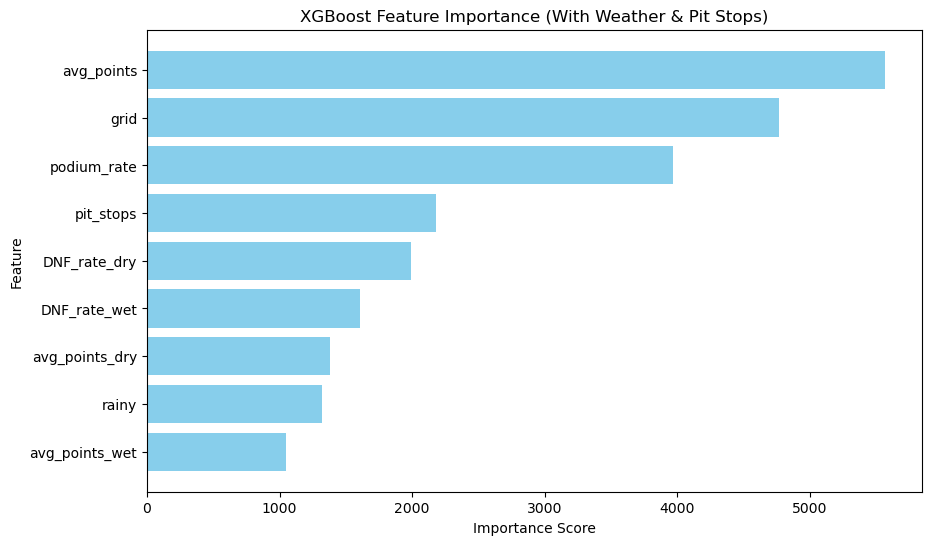

,Feature,Importance
6,avg_points,5567.0
0,grid,4768.0
5,podium_rate,3965.0
7,pit_stops,2177.0
1,DNF_rate_dry,1992.0
2,DNF_rate_wet,1605.0
3,avg_points_dry,1377.0
8,rainy,1317.0
4,avg_points_wet,1047.0


In [ ]:
if 'xgb_model_weather_pitstops' not in locals():
    print("Model not found. Retraining XGBoost with Weather & Pit Stops...")
    
    feature_columns = ["grid", "DNF_rate_dry", "DNF_rate_wet", "avg_points_dry",
                       "avg_points_wet", "podium_rate", "avg_points", "pit_stops", "rainy"]

    X = f1_processed[feature_columns]
    y = f1_processed["Top 3 Finish"]

    X.fillna(X.median(), inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    xgb_model_weather_pitstops = xgb.XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    )
    xgb_model_weather_pitstops.fit(X_train, y_train)

xgb_importance = xgb_model_weather_pitstops.get_booster().get_score(importance_type="weight")

importance_df = pd.DataFrame(list(xgb_importance.items()), columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance (With Weather & Pit Stops)")
plt.gca().invert_yaxis()  
plt.show()

importance_df

- Driver performance (avg_points, podium_rate) and starting grid position remain the most significant factors, suggesting that past success and track position heavily influence podium finishes.  
- Pit stops now play a stronger role (ranked 4th in importance), indicating that strategy and race management impact podium outcomes, though less than raw performance.  
- Weather conditions (rainy, DNF_rate_wet) have some influence, but not as much as expected, suggesting that while wet conditions increase unpredictability, historical driver performance and racecraft remain more decisive in podium finishes.

### Use real data on enhanced model to see if the results are accurate

In [ ]:
driver_ids = ["846", "857", "50", "847", "852", "848", "844", "1", "842", "832"]

driver_id_mapping = {
    "846": "NOR", "857": "PIA", "50": "VER", "847": "RUS", "852": "TSU",
    "848": "ALB", "844": "LEC", "1": "HAM", "842": "GAS", "832": "SAI"
}

grid_positions = {
    "846": 1, "857": 2, "50": 3, "847": 4, "852": 5, 
    "848": 6, "844": 7, "1": 8, "842": 9, "832": 10
}

feature_columns = ["grid", "DNF_rate_dry", "DNF_rate_wet", "avg_points_dry", 
                   "avg_points_wet", "podium_rate", "avg_points", "pit_stops", "rainy"]

upcoming_race_data = []
driver_names = []  

for driver_id in driver_ids:
    driver_data = f1_processed[f1_processed["driverId"] == driver_id]

    if driver_data.empty:
        print(f"Warning: No race data found for Driver {driver_id}, using default values.")
        driver_stats = {
            "grid": grid_positions.get(driver_id, 99),
            "DNF_rate_dry": 0.15,
            "DNF_rate_wet": 0.20,
            "avg_points_dry": 10.0,
            "avg_points_wet": 9.0,
            "podium_rate": 0.25,
            "avg_points": 10.5,
            "pit_stops": 2,  
            "rainy": 1  # Assume rainy race conditions
        }
    else:
        driver_stats = {
            "grid": grid_positions.get(driver_id, 99),
            "DNF_rate_dry": driver_data["DNF_rate_dry"].mean(),
            "DNF_rate_wet": driver_data["DNF_rate_wet"].mean(),
            "avg_points_dry": driver_data["avg_points_dry"].mean(),
            "avg_points_wet": driver_data["avg_points_wet"].mean(),
            "podium_rate": driver_data["podium_rate"].mean(),
            "avg_points": driver_data["avg_points"].mean(),
            "pit_stops": driver_data["pit_stops"].mean(),
            "rainy": 1  
        }

    driver_names.append(driver_id_mapping.get(driver_id, driver_id))  # Use reference name, else keep ID

    upcoming_race_data.append(driver_stats)

upcoming_race_df = pd.DataFrame(upcoming_race_data)

upcoming_race_df["grid"] = upcoming_race_df["grid"].astype(int)

upcoming_race_df = upcoming_race_df[feature_columns]

predicted_podiums = xgb_model_weather_pitstops.predict_proba(upcoming_race_df)[:, 1]

upcoming_race_df["Driver"] = driver_names  
upcoming_race_df["Podium Probability"] = pd.Series(predicted_podiums)  

upcoming_race_df = upcoming_race_df.sort_values(by="Podium Probability", ascending=False)

print("\nPredicted Podium Probabilities for Australian GP (With Weather & Pit Stops):")
print(upcoming_race_df[["Driver", "Podium Probability"]])


Predicted Podium Probabilities for Australian GP (With Weather & Pit Stops):
  Driver  Podium Probability
0    NOR            0.784195
7    HAM            0.716687
1    PIA            0.642660
3    RUS            0.077402
6    LEC            0.014743
9    SAI            0.004950
2    VER            0.000584
4    TSU            0.000268
8    GAS            0.000221
5    ALB            0.000108


Actual result:  
NOR: 1  
VER: 2  
RUS: 3  
ALB: 5  
LEC: 8  
PIA: 9  
HAM: 10  
GAS: 11  
TSU: 12  
SAI: DNF

If ruling out Hamilton (debuting with new team, might not be familiar with the car yet), Piastri (huge spin during last couple laps), Norris and Russell is top 2, which is close to the actual result.